# S or R? Unveiling E. Coli’s Cefepime Resistance Patterns
###  Anayna Singh
December 5, 2024



Antibiotic resistance is a critical global health challenge, 
and effective predictive models can aid in understanding 
and combating it.
 In this project I built a predictive model for Cefepime 
Susceptibility (S) vs. Resistance (R) in Escherichia coli.

In [29]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from tensorflow import keras
from collections import defaultdict
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import shap  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from tqdm import tqdm

In [3]:
# Loading the dataset

seed = 130

def load_data():
  
    # Presence absence features
    train_pa_genes = pd.read_csv('../data/train_test_data/train_pa_genes.csv').set_index('genome_id')
    test_pa_genes = pd.read_csv('../data/train_test_data/test_pa_genes.csv').set_index('genome_id')
    
    # Load Kmer data
    train_kmers = np.load('../data/train_test_data/train_kmers.npy', allow_pickle=True)
    test_kmers = np.load('../data/train_test_data/test_kmers.npy', allow_pickle=True)

    # Load target data & IDs
    y_train = np.load('../data/train_test_data/y_train.npy', allow_pickle=True)
    y_train_ids = np.load('../data/train_test_data/train_ids.npy', allow_pickle=True).astype(str)
    y_test_ids = np.load('../data/train_test_data/test_ids.npy', allow_pickle=True).astype(str)

    # Load raw gene data for optional neural network section
    train_gene_alignment = pd.read_csv('../data/train_test_data/train_genes.csv')
    
    return train_pa_genes, test_pa_genes, train_kmers, test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment

train_pa_genes, test_pa_genes, X_train_kmers, X_test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment = load_data()

In [4]:
# Dataset Processing 

X_train_pa = np.array(train_pa_genes)
X_test_pa = np.array(test_pa_genes)

In [5]:
# Sample Weighting

sample_weights = sklearn.utils.class_weight.compute_sample_weight("balanced", y_train)

# Check the weights for a few samples
pd.DataFrame(list(zip(y_train[0:10], sample_weights[0:10])), columns=['y_train', 'weight'])

,y_train,weight
0,[S],0.625418
1,[S],0.625418
2,[S],0.625418
3,[S],0.625418
4,[S],0.625418
5,[S],0.625418
6,[R],2.493333
7,[S],0.625418
8,[R],2.493333
9,[R],2.493333


Used sample weighting here to deal with the imbalanced classes and checked the weights to make sure they're sensible with R being upweighted and S downweighted.

In [6]:
# Combine PA features and k-mer features
X_train = np.hstack((X_train_pa, X_train_kmers))
X_train = X_train.astype(np.float32)
X_test = np.hstack((X_test_pa, X_test_kmers))
X_test = X_test.astype(np.float32)

Joined the features presence-absence data (genes) and k-mer representations together into a single feature matrix.

Feature Importance

c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Total PA Feature Importance: 0.00
Total k-mer Feature Importance: 1.00


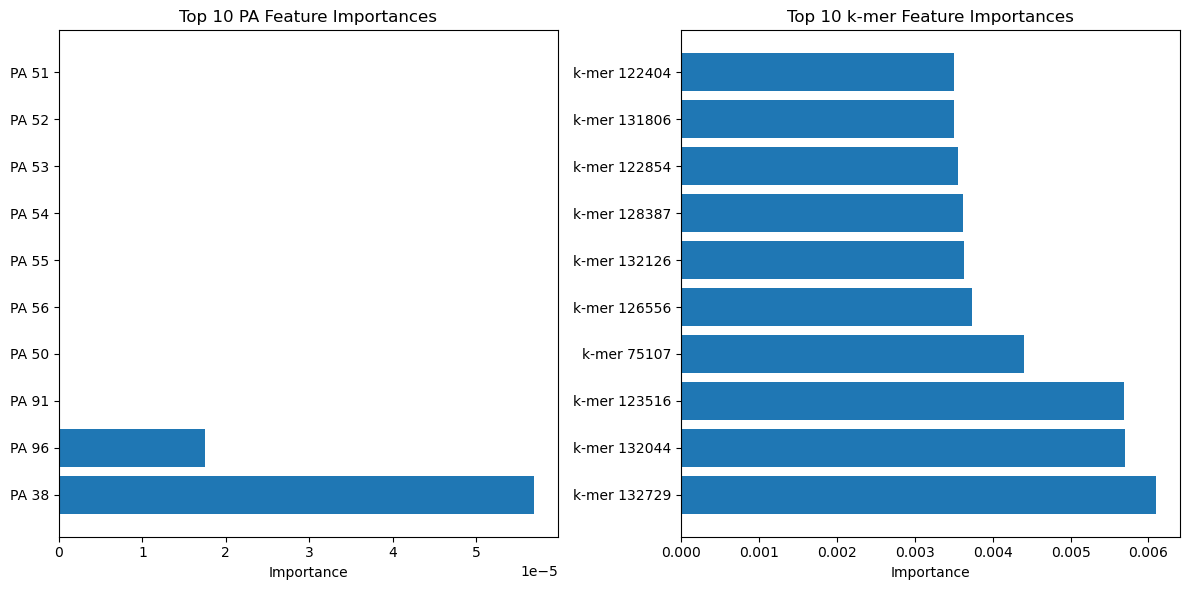

In [7]:

# Step 1: Train a Random Forest model
rf_model = RandomForestClassifier(random_state=seed, n_estimators=100, class_weight="balanced")
rf_model.fit(X_train, y_train, sample_weight=sample_weights)

# Step 2: Calculate feature importances
feature_importances = rf_model.feature_importances_

# Step 3: Separate PA and k-mer feature importance
num_pa_features = X_train_pa.shape[1]
pa_importances = feature_importances[:num_pa_features]
kmer_importances = feature_importances[num_pa_features:]

# Aggregate importance by feature type
total_pa_importance = np.sum(pa_importances)
total_kmer_importance = np.sum(kmer_importances)

# Display results
print("Total PA Feature Importance: {:.2f}".format(total_pa_importance))
print("Total k-mer Feature Importance: {:.2f}".format(total_kmer_importance))

# Step 4: Visualize feature importances (Optional)
import matplotlib.pyplot as plt

# Sort PA and k-mer importances for visualization
sorted_pa_idx = np.argsort(pa_importances)[::-1]
sorted_kmer_idx = np.argsort(kmer_importances)[::-1]

plt.figure(figsize=(12, 6))

# Plot top 10 PA features
plt.subplot(1, 2, 1)
plt.barh(range(10), pa_importances[sorted_pa_idx[:10]])
plt.yticks(range(10), [f"PA {i}" for i in sorted_pa_idx[:10]])
plt.title("Top 10 PA Feature Importances")
plt.xlabel("Importance")

# Plot top 10 k-mer features
plt.subplot(1, 2, 2)
plt.barh(range(10), kmer_importances[sorted_kmer_idx[:10]])
plt.yticks(range(10), [f"k-mer {i}" for i in sorted_kmer_idx[:10]])
plt.title("Top 10 k-mer Feature Importances")
plt.xlabel("Importance")

plt.tight_layout()
plt.show()

Baseline model

In [27]:
# Split the training data (X_train, y_train) into 80% for training and 20% for testing
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [33]:
# Convert the arrays into DataFrames for easier CSV export
X_train_new_df = pd.DataFrame(X_train_new)
X_test_new_df = pd.DataFrame(X_test_new)
y_train_new_df = pd.DataFrame(y_train_new, columns=['target'])
y_test_new_df = pd.DataFrame(y_test_new, columns=['target'])

# Combine them into one DataFrame (optional)
train_data = pd.concat([X_train_new_df, y_train_new_df], axis=1)
test_data = pd.concat([X_test_new_df, y_test_new_df], axis=1)

# Save the data to CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("CSV files created successfully!")

CSV files created successfully!


In [28]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train_new, y_train_new)

# Make predictions
y_pred = knn_model.predict(X_test_new)

# Evaluate the model
accuracy = accuracy_score(y_test_new, y_pred)
print("KNN Model Accuracy: {:.2f}%".format(accuracy * 100))

# Display classification report
print(classification_report(y_test_new, y_pred))

c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Model Accuracy: 86.00%
              precision    recall  f1-score   support

           R       0.76      0.56      0.64        34
           S       0.88      0.95      0.91       116

    accuracy                           0.86       150
   macro avg       0.82      0.75      0.78       150
weighted avg       0.85      0.86      0.85       150



Random Forest, Gradient Boosting, LightGBM, XGBoost and CNN models

In [32]:
seed = 42  # Random seed

# Subsample the data (reduce dataset size for testing)
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(X_train_new, y_train_new, test_size=0.7, random_state=seed, stratify=y_train_new)

# Function for tuning
def tune_model_randomized(model, param_distributions, X, y, n_iter=10, cv=3):
    random_search = RandomizedSearchCV(
        model, param_distributions, n_iter=n_iter, cv=cv,
        scoring='accuracy', random_state=seed, n_jobs=1, verbose=1
    )
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_score_

# Random Forest
rf_param_distributions = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomForestClassifier(random_state=seed)
best_rf, rf_score = tune_model_randomized(rf_model, rf_param_distributions, X_sample, y_sample)

print(f"Best Random Forest Score: {rf_score}")
print(f"Best Random Forest Parameters: {best_rf.get_params()}")


# Perform cross-validation on the best models
cv_scores = {
    'Random Forest': cross_val_score(best_rf, X_sample, y_sample, cv=3, scoring='accuracy'),
    
}

# Print cross-validation scores
for model, scores in cv_scores.items():
    print(f"\n{model} CV Scores: {scores}")
    print(f"{model} Mean CV Score: {np.mean(scores)}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

Best Random Forest Score: 0.8603578154425612
Best Random Forest Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Random Forest CV Scores: [0.83333333 0.88333333 0.86440678]
Random Forest Mean CV Score: 0.8603578154425612


In [34]:

# Gradient Boosting
gb_param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
gb_model = GradientBoostingClassifier(random_state=seed)
best_gb, gb_score = tune_model_randomized(gb_model, gb_param_distributions, X_sample, y_sample)

print(f"Best Gradient Boosting Score: {gb_score}")
print(f"Best Gradient Boosting Parameters: {best_gb.get_params()}")
cv_scores = {'Gradient Boosting': cross_val_score(best_gb, X_sample, y_sample, cv=3, scoring='accuracy')}
# Print cross-validation scores
for model, scores in cv_scores.items():
    print(f"\n{model} CV Scores: {scores}")
    print(f"{model} Mean CV Score: {np.mean(scores)}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d

Best Gradient Boosting Score: 0.8886064030131827
Best Gradient Boosting Parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\anayn\miniconda3\envs\ml_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Gradient Boosting CV Scores: [0.88333333 0.83333333 0.94915254]
Gradient Boosting Mean CV Score: 0.8886064030131827
